# 2D QLIPP reconstruction
This reconstruction is based on the QLIPP paper ([here](https://elifesciences.org/articles/55502)): <br>
``` S.-M. Guo, L.-H. Yeh, J. Folkesson, I. E. Ivanov, A. P. Krishnan, M. G. Keefe, E. Hashemi, D. Shin, B. B. Chhun, N. H. Cho, M. D. Leonetti, M. H. Han, T. J. Nowakowski, S. B. Mehta , "Revealing architectural order with quantitative label-free imaging and deep learning," eLife 9:e55502 (2020).```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift

import waveorder as wo

%matplotlib inline
plt.style.use(['dark_background']) # Plotting option for dark background


### Load simulated data

In [2]:
# Load simulations


file_name = '2D_QLIPP_simulation.npz'

array_loaded = np.load(file_name)
list_of_array_names = sorted(array_loaded)

for array_name in list_of_array_names:
    globals()[array_name] = array_loaded[array_name]

print(list_of_array_names)


['I_meas', 'NA_illu', 'NA_obj', 'Source_cont', 'Stokes_out', 'chi', 'lambda_illu', 'n_media', 'ps', 'z_defocus']


### Reconstruction of Stokes parameters and anisotropy

In [3]:
_, N, M, _ = I_meas.shape
cali        = False               
bg_option   = 'global'            

setup = wo.waveorder_microscopy((N,M), lambda_illu, ps, NA_obj, NA_illu, z_defocus, chi, n_media=n_media, illu_mode='BF')
S_image_recon = setup.Stokes_recon(I_meas)
S_image_tm = setup.Stokes_transform(S_image_recon)
Recon_para =setup.Polarization_recon(S_image_tm) # Without accounting for diffraction

In [4]:
wo.parallel_4D_viewer(np.transpose(S_image_recon,(3,0,1,2)), num_col=2, size=5, origin='lower', \
                      set_title=True, titles=[r'$S_0$',r'$S_1$',r'$S_2$',r'$S_3$'])

interactive(children=(IntSlider(value=0, description='stack_idx', max=4), Output()), _dom_classes=('widget-int…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [8]:
wo.parallel_4D_viewer(np.transpose(Recon_para,(3,0,1,2)), num_col=2, size=5, origin='lower',\
                     set_title=True, titles=[r'Retardance',r'2D Orientation',r'Brightfield',r'Degree of polarization'])

interactive(children=(IntSlider(value=0, description='stack_idx', max=4), Output()), _dom_classes=('widget-int…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [9]:
# animate through z for rendering of retardance + 2D orientation
wo.hsv_stack_viewer([np.transpose(Recon_para[1],(2,0,1)), np.transpose(Recon_para[0],(2,0,1))], max_val=1, origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx', max=4), Output()), _dom_classes=('widget-int…

<function waveorder.visual.hsv_stack_viewer.<locals>.interact_plot_hsv(stack_idx)>

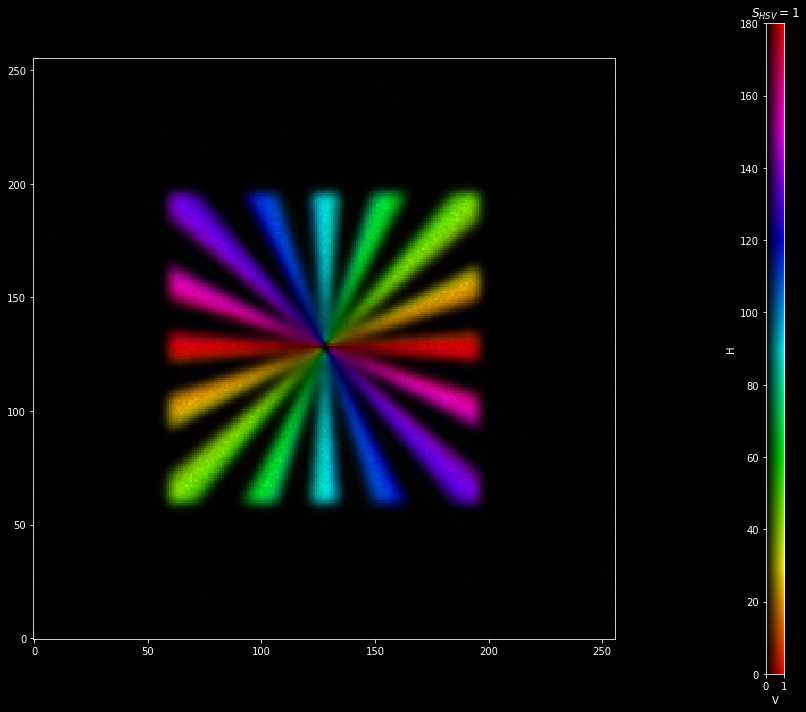

In [10]:
wo.plot_hsv([Recon_para[1,:,:,2], Recon_para[0,:,:,2]],max_val=1, origin='lower', size=10)

## 2D retardance and orientation reconstruction with $S_1$ and $S_2$ 

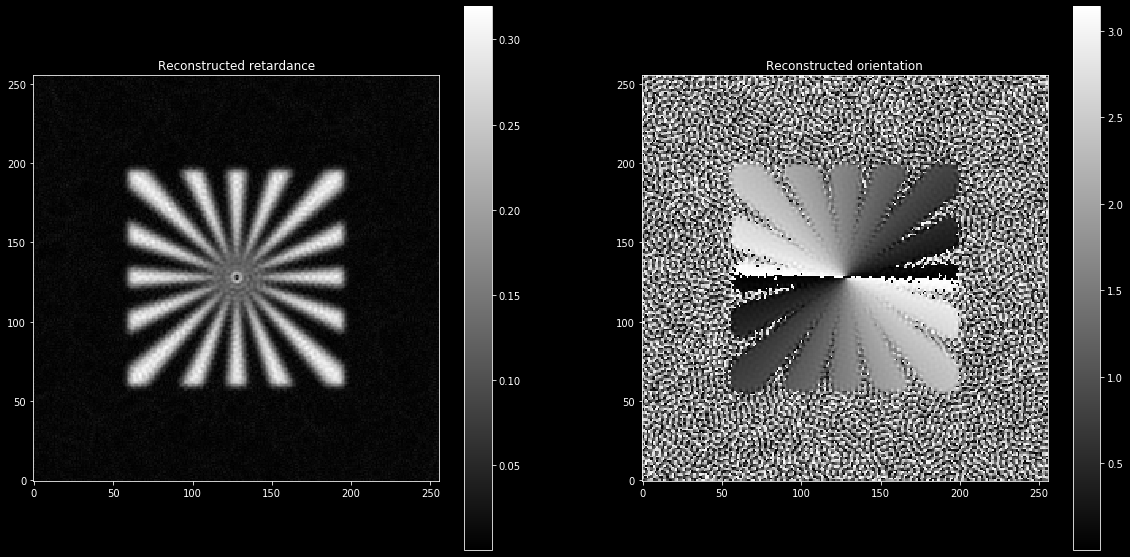

In [11]:
# Diffraction aware reconstruction assuming slowly varying transmission.

reg = 1e-3

S1_stack = S_image_recon[1].copy()/S_image_recon[0].mean()
S2_stack = S_image_recon[2].copy()/S_image_recon[0].mean()

Rt_sample, Sa_sample = setup.Birefringence_recon(S1_stack, S2_stack, reg = reg)

wo.plot_multicolumn(np.array([Rt_sample, Sa_sample]), num_col=2, size=10, \
                    set_title=True, titles = ['Reconstructed retardance', 'Reconstructed orientation'], origin='lower')


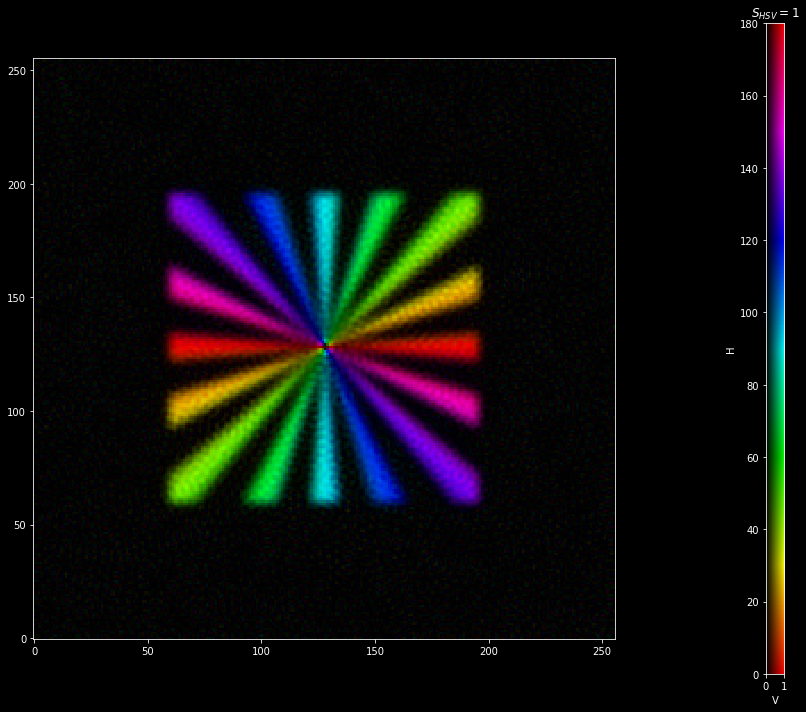

In [12]:
wo.plot_hsv([Sa_sample, Rt_sample], size=10, origin='lower')

## 2D Phase reconstruction with $S_0$

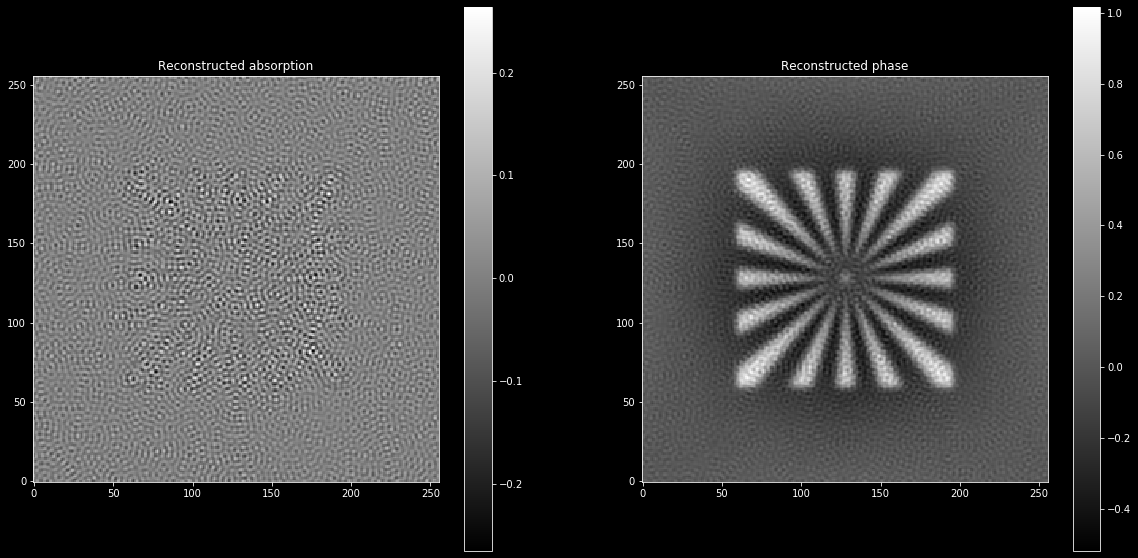

In [13]:
# Tikhonov regularizer
reg_u = 1e-3
reg_p = 1e-3
S0_stack = S_image_recon[0].copy()

mu_sample, phi_sample = setup.Phase_recon(S0_stack, method='Tikhonov', reg_u = reg_u, reg_p = reg_p)

wo.plot_multicolumn(np.array([mu_sample, phi_sample]), num_col=2, size=10, \
                    set_title=True, titles = ['Reconstructed absorption', 'Reconstructed phase'], origin='lower')

Number of iteration computed (1 / 10)
Number of iteration computed (2 / 10)
Number of iteration computed (3 / 10)
Number of iteration computed (4 / 10)
Number of iteration computed (5 / 10)
Number of iteration computed (6 / 10)
Number of iteration computed (7 / 10)
Number of iteration computed (8 / 10)
Number of iteration computed (9 / 10)
Number of iteration computed (10 / 10)


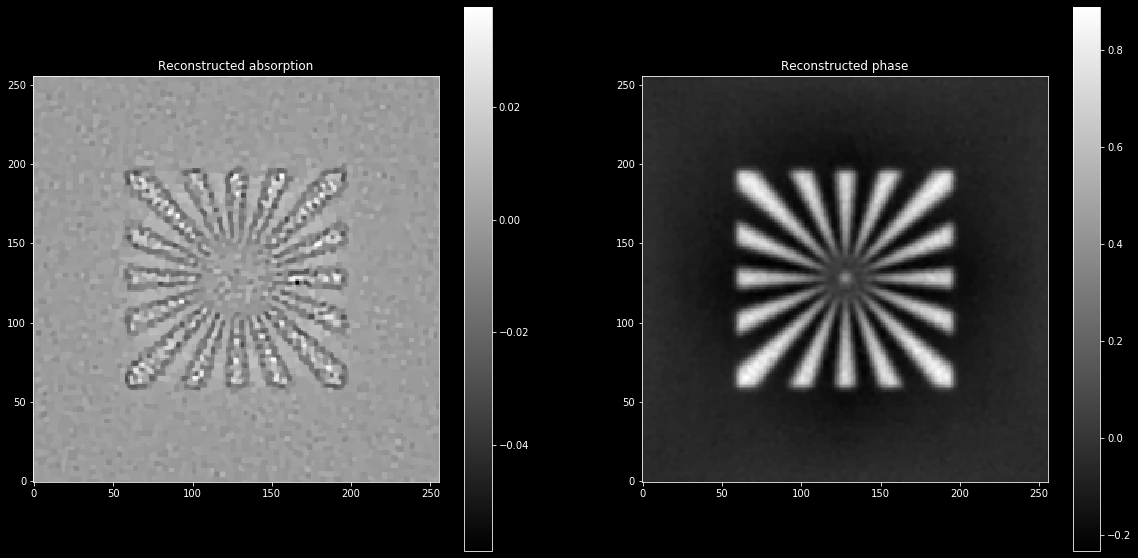

In [14]:
# TV regularizer
lambda_u = 3e-3
lambda_p = 1e-3
S0_stack = S_image_recon[0].copy()

mu_sample_TV, phi_sample_TV = setup.Phase_recon(S0_stack, method='TV', lambda_u = lambda_u, lambda_p = lambda_p, itr = 10, rho=1)

wo.plot_multicolumn(np.array([mu_sample_TV, phi_sample_TV]), num_col=2, size=10, \
                    set_title=True, titles = ['Reconstructed absorption', 'Reconstructed phase'], origin='lower')